# Projet final du Kit Data Science 2020

In [1]:
import requests
import re 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import cartopy as ctp
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

## Acquisition et chargement des données

On commence par récupérer les fichiers Excel sur https://www.vendeeglobe.org/fr/classement . Pour cela, et au vu du nombre de téléchargement quotidien à faire, j'ai choisi dans un premier temps de récupérer les différentes date et heure (qui compose le nom des fichier Excel) à l'aide de BeautifulSoup sur la page classement.

Cette opération peut être assez longue !

In [2]:
def extract_url_ranking(url):
    # début de l'URL commun à tout les download des fichiers Excel 
    debutUrl = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_"
    r = requests.get(url)
    html_doc = r.content
    soup = BeautifulSoup(html_doc, 'html.parser')
    tag = soup.findAll('option')
    listUrl = []
    listDate = []
    for li_tag in tag:
        for string in li_tag:
            # j'extrais les digits à l'aide d'une regex
            delElement = re.sub('\D', '', string)
            #si il n'y a plus rien dans delElement, c'est que ce n'est pas interessant 
            # on skip !
            if delElement == '':
                continue
            listDate.append(string)
            #reconstruction de l'URL de download
            finUrl = delElement[:8] + "_" + delElement[8:]
            listUrl.append(debutUrl + finUrl + ".xlsx")
    return listUrl, listDate

In [3]:
def download_from_url_ranking(url):
    listUrl, listDate = extract_url_ranking(url)
    for urls in listUrl:
        nameExcel = urls[-32:]
        resp = requests.get(urls)
        with open(nameExcel, 'wb') as output:
            output.write(resp.content)

In [4]:
download_from_url_ranking("https://www.vendeeglobe.org/fr/classement")

J'ai réutilisé la fonction du premier projet; en effet, on en aura besoin pour correctement représenté les trajets sur les cartes :)

In [5]:
def dms2dec(deg, mn, sec):
    return deg + mn/60 + sec/3600

Dans la prochaine fonction, nous allons convertir les différents tableaux Excel en DataFrame pandas afin de simplifier le traitement des données. Nous allons pour cela concaténer les différents fichiers Excel.

Cette fonction va aussi nous permettre de clean les données : on va extraire dans les string des données les float nous permettant la futur analyse. 

On peut remarquer l'ajout du colonne Date avec l'objet Datetime afin de différencier les différents fichiers Excel.

J'ai ajouté les unités dans le nom des colonnes afin que le df reste compréhensible (en particulier car les unités dans la marine sont différentes)

In [6]:
def ranking_from_url_to_pandas(url):
    listUrl, listDate = extract_url_ranking(url)
    dates = []
    # création de la colonne Date à l'aide de l'objet Datetime
    for date in listDate :
        dates.append(dt.datetime(int(date[2:6]), int(date[7:9]), int(date[10:12]), int(date[13:15]), int(date[16:18])))
    j = 0
    prevDF = pd.DataFrame()
    for i in listUrl:
        nameExcel = i[-32:]
        df = pd.read_excel(nameExcel, header = 4)
        df = df.drop(df.columns[[0]], axis='columns')
        df.columns = ['Rang', 'Nat. / Voile', 'Skipper', 'Heure FR',
              'Latitude', 'Longitude', 'Cap Depuis 30 minutes (deg)',
              'Vitesse Depuis 30 minutes (kts)', 'VMG Depuis 30 minutes (kts)',
              'Distance Depuis 30 minutes (nm)', 'Cap Depuis le dernier classement (deg)',
              'Vitesse Depuis le dernier classement (kts)', 'VMG Depuis le dernier classement (kts)',
              'Distance Depuis le dernier classement (nm)', 'Cap Depuis 24 heures (deg)',
              'Vitesse Depuis 24 heures (kts)', 'VMG Depuis 24 heures (kts)',
              'Distance Depuis 24 heures (nm)', 'DTF (nm)', 'DTL (nm)']
        #certaines lignes sont complétement vide (par exemple celles du premier document Excel)
        df = df.dropna()
        df['Skipper'] = df['Skipper'].apply(lambda x : x.split('\n')[0])
        df['Skipper'] = df['Skipper'].str.title()
        df['Rang'] = df['Rang'].apply(lambda x : int(x))
        df = df.replace({'\n': ' '}, regex=True)
        df.insert(0, 'Date', dates[j])
        #Concaténation des DataFrame au fur et à mesure 
        prevDF = pd.concat([prevDF, df])
        j+=1
    df = prevDF
    
    # on extrait dans le bloque de code suivant les valeurs des colonnes afin de pouvoir traiter les données
    df['Cap Depuis 30 minutes (deg)'] = df['Cap Depuis 30 minutes (deg)'].apply(lambda x : float(str(x)[0:-1]))
    df['Cap Depuis le dernier classement (deg)'] = df['Cap Depuis le dernier classement (deg)'].apply(lambda x : float(str(x)[0:-1]))
    df['Cap Depuis 24 heures (deg)'] = df['Cap Depuis 24 heures (deg)'].apply(lambda x : float(str(x)[0:-1]))
    df['Vitesse Depuis 30 minutes (kts)'] = df['Vitesse Depuis 30 minutes (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['VMG Depuis 30 minutes (kts)'] = df['VMG Depuis 30 minutes (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['Vitesse Depuis le dernier classement (kts)'] = df['Vitesse Depuis le dernier classement (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['VMG Depuis le dernier classement (kts)'] = df['VMG Depuis le dernier classement (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['Vitesse Depuis 24 heures (kts)'] = df['Vitesse Depuis 24 heures (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['VMG Depuis 24 heures (kts)'] = df['VMG Depuis 24 heures (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['Distance Depuis 30 minutes (nm)'] = df['Distance Depuis 30 minutes (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['Distance Depuis le dernier classement (nm)'] = df['Distance Depuis le dernier classement (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['Distance Depuis 24 heures (nm)'] = df['Distance Depuis 24 heures (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['Latitude'] = df['Latitude'].apply(lambda x : dms2dec(float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])) if 'N' in str(x) else dms2dec(-float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])))
    df['Longitude'] = df['Longitude'].apply(lambda x : dms2dec(float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])) if 'N' in str(x) else dms2dec(-float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])))
    df['DTF (nm)'] = df['DTF (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['DTL (nm)'] = df['DTL (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df.reset_index(drop = True, inplace = True)
    return df

In [7]:
df_ranking = ranking_from_url_to_pandas("https://www.vendeeglobe.org/fr/classement")
df_ranking

,Date,Rang,Nat. / Voile,Skipper,Heure FR,Latitude,Longitude,Cap Depuis 30 minutes (deg),Vitesse Depuis 30 minutes (kts),VMG Depuis 30 minutes (kts),Distance Depuis 30 minutes (nm),Cap Depuis le dernier classement (deg),Vitesse Depuis le dernier classement (kts),VMG Depuis le dernier classement (kts),Distance Depuis le dernier classement (nm),Cap Depuis 24 heures (deg),Vitesse Depuis 24 heures (kts),VMG Depuis 24 heures (kts),Distance Depuis 24 heures (nm),DTF (nm),DTL (nm)
0,2020-11-30 21:00:00,1,FRA 79,Charlie Dalin,21:30 FR,-40.816389,-16.296944,101.0,14.8,14.8,7.4,119.0,16.2,15.7,64.8,120.0,16.8,16.6,403.4,17584.6,0.0
1,2020-11-30 21:00:00,2,FRA 59,Thomas Ruyant,20:00 FR -90min,-40.839167,-10.166667,96.0,19.5,19.3,9.7,98.0,18.5,18.4,46.4,103.0,17.3,17.2,406.4,17842.8,258.2
2,2020-11-30 21:00:00,3,FRA 18,Louis Burton,21:30 FR,-43.789444,-8.048889,91.0,18.5,18.3,9.2,93.0,18.0,17.9,72.1,102.0,18.5,18.4,443.3,17886.9,302.3
3,2020-11-30 21:00:00,4,FRA 4,Sébastien Simon,21:30 FR,-40.511667,-8.510278,68.0,14.5,11.7,1.2,89.0,16.3,15.7,65.4,109.0,16.9,16.8,404.5,17939.8,355.2
4,2020-11-30 21:00:00,5,FRA 17,Yannick Bestaven,21:30 FR,-39.093333,-8.702500,331.0,7.6,-5.4,0.6,26.0,9.9,1.9,39.7,107.0,14.8,14.8,356.2,17957.6,372.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,2020-11-08 14:00:00,27,FRA 72,Alexia Barrier,15:30 FR,46.439722,-0.174444,236.0,10.9,10.8,0.2,357.0,0.0,0.0,2789.4,194.0,0.6,0.4,4.5,24295.4,1.6
4394,2020-11-08 14:00:00,28,FRA 27,Isabelle Joschke,15:26 FR -4min,46.427222,-0.193889,238.0,13.8,13.5,0.2,358.0,0.0,0.0,2788.5,187.0,0.2,0.2,5.2,24295.5,1.6
4395,2020-11-08 14:00:00,29,FRA 4,Sébastien Simon,15:29 FR -1min,46.437500,-0.179722,235.0,13.4,13.4,0.7,357.0,0.0,0.0,2789.3,192.0,0.2,0.1,4.5,24295.5,1.6
4396,2020-11-08 14:00:00,30,FRA 50,Miranda Merron,15:28 FR -2min,46.427500,-0.190556,237.0,11.4,11.3,0.4,358.0,0.0,0.0,2788.9,188.0,0.2,0.2,4.8,24295.6,1.7


## Extraction des fiches techniques pour chacun des voiliers

Cette fois ci, l'extraction des données va se faire uniquement dans le code HTML (web scrapping).

ça n'a pas été évident : les données sont bien cachés dans le code. De plus, elle n'apparaisse pas (caché sur le rendu js).

In [8]:
def extract_url_spec(url):
    r = requests.get(url)
    html_doc = r.content
    soup = BeautifulSoup(html_doc, 'html.parser')
    tag = soup.findAll("ul", {"class": "boats-list__popup-specs-list"})
    header = []
    # on commence par extraire le nom des colonnes (à gauche des ":") dans le code
    for e in tag[0] :
        e = str(e)
        index = e.find(' : ')
        if(index != -1):
            header.append(e[4:index])
    data = []
    for element in tag:
        absent = []
        # j'ai eu beaucoup de difficulté à placer correctement les informations dans les colonnes  :
        # il n'y a pas la même quantité d'information entre les différents bateaux ni le même formalisme...
        i = 0
        for h in header :
            if not(h in str(element)):
                absent.append(i)
            i+=1
        if len(absent) == len(header):
            continue
        row = []
        for spec in element :
            spec = str(spec)
            index = spec.find(' : ')
            if index != -1 :
                if len(row) in absent :
                    row.append(np.nan)
                    if len(row) in absent :
                        row.append(np.nan)
                row.append(spec[index+3:-5])
        data.append(row)
    df = pd.DataFrame(data, columns = header)
    
    # scraping du nom des skippers
    nameSkipper = soup.findAll("span", {"class": "boats-list__skipper-name"})
    names = []
    for name in nameSkipper :
        name = str(name)
        indexMin = name.find('name">')
        indexMax = name.find('</span>')
        if(indexMin != -1 and indexMax != -1):
            # j'ai du corrigr des nom à la main pour pouvoir faire le merge avec le df des classements
            # sam dans ce df est samantha dans l'autre. Pour les autre que j'ai du corriger à la main je n'ai
            # pas compris en quoi ils étaient différents du premier df
            if 'Sam' in name:
                names.append('Samantha Davies')
            elif 'Alan' in name :
                names.append('Alan Roura')
            elif 'Arnaud' in name :
                names.append('Arnaud Boissieres')
            else :
                names.append(name[indexMin+6:indexMax])
    df.insert(0, 'Skipper', names)
    df['Skipper'] = df['Skipper'].str.title()
    
    # comme pour le premier df, on extrait les valeurs numériques afin de pouvoir les traités
    df['Longueur'] = df['Longueur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    pd.to_numeric(df['Longueur'], errors='raise')
    df['Largeur'] = df['Largeur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    pd.to_numeric(df['Largeur'], errors='raise')
    df["Tirant d'eau"] = df["Tirant d'eau"].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    pd.to_numeric(df["Tirant d'eau"], errors='raise')
    df["Déplacement (poids)"] = df["Déplacement (poids)"].apply(lambda x : ((str(x).replace(',', '.')).replace('tonne', ''))[0:-1])
    pd.to_numeric(df["Déplacement (poids)"], errors='coerce')
    df["Hauteur mât"] = df["Hauteur mât"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-1])
    pd.to_numeric(df["Hauteur mât"], errors='raise')
    df["Surface de voiles au près"] = df["Surface de voiles au près"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-2])
    pd.to_numeric(df["Surface de voiles au près"], errors='raise')
    df["Surface de voiles au portant"] = df["Surface de voiles au portant"].apply(lambda x : (str(x).replace(',', '.'))[0:-2])
    pd.to_numeric(df["Surface de voiles au portant"], errors='raise')

    return df

In [9]:
df_boat = extract_url_spec("https://www.vendeeglobe.org/fr/glossaire")
df_boat

,Skipper,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice Amedeo,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.50,7,foils,29,monotype,320,570
1,Romain Attanasio,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.50,9,2,28,acier forgé,280,560
2,Alexia Barrier,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.50,9,2,29,acier,260,580
3,Yannick Bestaven,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.50,8,foils,29,acier mécano soudé,310,550
4,Jérémie Beyou,08,NaN,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.50,8,foils,29,acier,320,600
5,Arnaud Boissieres,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,18.28,5.65,4.50,7.9,foils,29,basculante avec vérin,300,610
6,Louis Burton,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,18.28,5.80,4.50,7.6,foils,28,acier,300,600
7,Didac Costa,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,02 Février 2000,18.28,5.30,4.50,8.9,2,26,acier,240,470
8,Manuel Cousin,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,18.28,5.80,4.50,9,2 asymétriques,28.5,basculante sur vérin hydraulique,270,560
9,Clarisse Cremer,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,18.28,5.70,4.5,7.7,2,29,acier forgé,340,570


## Rapprochement des données des voiliers avec celle des classements

Pour rapprocher les deux premiers df, nous allons les merge sur le nom des skippers, d'où l'importance d'ajouter cette colonne dans le précédent df.

J'ai choisi de classer le df avec les dates décroissantes puis le classement croissant.

In [10]:
def merge_df(df_ranking, df_boat):
    df = pd.merge(df_ranking, df_boat, how='outer', on='Skipper', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
    df = df.sort_values(by = ['Date', 'Rang'], ascending = [False, True])
    df.reset_index(drop = True, inplace = True)
    return df

In [11]:
df_merge = merge_df(df_ranking, df_boat)
df_merge

,Date,Rang,Nat. / Voile,Skipper,Heure FR,Latitude,Longitude,Cap Depuis 30 minutes (deg),Vitesse Depuis 30 minutes (kts),VMG Depuis 30 minutes (kts),Distance Depuis 30 minutes (nm),Cap Depuis le dernier classement (deg),Vitesse Depuis le dernier classement (kts),VMG Depuis le dernier classement (kts),Distance Depuis le dernier classement (nm),Cap Depuis 24 heures (deg),Vitesse Depuis 24 heures (kts),VMG Depuis 24 heures (kts),Distance Depuis 24 heures (nm),DTF (nm),DTL (nm),Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,2020-11-30 21:00:00,1,FRA 79,Charlie Dalin,21:30 FR,-40.816389,-16.296944,101.0,14.8,14.8,7.4,119.0,16.2,15.7,64.8,120.0,16.8,16.6,403.4,17584.6,0.0,FRA 79,NaN,Verdier,CDK technologies - MerConcept,05 Août 2019,18.28,5.85,4.50,8,foils,29,acier,350,560
1,2020-11-30 21:00:00,2,FRA 59,Thomas Ruyant,20:00 FR -90min,-40.839167,-10.166667,96.0,19.5,19.3,9.7,98.0,18.5,18.4,46.4,103.0,17.3,17.2,406.4,17842.8,258.2,NaN,NaN,Verdier,Persico,03 Septembre 2019,18.28,5.85,4.50,8,foils,29,acier forgé,350,560
2,2020-11-30 21:00:00,3,FRA 18,Louis Burton,21:30 FR,-43.789444,-8.048889,91.0,18.5,18.3,9.2,93.0,18.0,17.9,72.1,102.0,18.5,18.4,443.3,17886.9,302.3,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,18.28,5.80,4.50,7.6,foils,28,acier,300,600
3,2020-11-30 21:00:00,4,FRA 4,Sébastien Simon,21:30 FR,-40.511667,-8.510278,68.0,14.5,11.7,1.2,89.0,16.3,15.7,65.4,109.0,16.9,16.8,404.5,17939.8,355.2,4,NaN,Juan Kouyoumdjian,CDK Technologies / Assemblage : Team ARKEA PAPREC,19 Juillet 2019,18.28,5.70,4.50,8,foiler,29,Inox usiné,260,600
4,2020-11-30 21:00:00,5,FRA 17,Yannick Bestaven,21:30 FR,-39.093333,-8.702500,331.0,7.6,-5.4,0.6,26.0,9.9,1.9,39.7,107.0,14.8,14.8,356.2,17957.6,372.9,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.50,8,foils,29,acier mécano soudé,310,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,2020-11-08 14:00:00,27,FRA 72,Alexia Barrier,15:30 FR,46.439722,-0.174444,236.0,10.9,10.8,0.2,357.0,0.0,0.0,2789.4,194.0,0.6,0.4,4.5,24295.4,1.6,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.50,9,2,29,acier,260,580
4394,2020-11-08 14:00:00,28,FRA 27,Isabelle Joschke,15:26 FR -4min,46.427222,-0.193889,238.0,13.8,13.5,0.2,358.0,0.0,0.0,2788.5,187.0,0.2,0.2,5.2,24295.5,1.6,FRA 27,"Quéguiner, Safran",Verdier - VPLP,Chantier Naval de Larros,04 Juillet 2007,18.28,5.60,4.50,7.7,foils,27,acier,300,650
4395,2020-11-08 14:00:00,29,FRA 4,Sébastien Simon,15:29 FR -1min,46.437500,-0.179722,235.0,13.4,13.4,0.7,357.0,0.0,0.0,2789.3,192.0,0.2,0.1,4.5,24295.5,1.6,4,NaN,Juan Kouyoumdjian,CDK Technologies / Assemblage : Team ARKEA PAPREC,19 Juillet 2019,18.28,5.70,4.50,8,foiler,29,Inox usiné,260,600
4396,2020-11-08 14:00:00,30,FRA 50,Miranda Merron,15:28 FR -2min,46.427500,-0.190556,237.0,11.4,11.3,0.4,358.0,0.0,0.0,2788.9,188.0,0.2,0.2,4.8,24295.6,1.7,FRA50,"Great America IV, Mirabaud, Temenos",Owen Clarke,"Southern Ocean Marine, Tauranga",04 Mai 2006,18.28,5.50,4.50,8.5,2,28,carbone,330,600


## Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers

Nous passons à présent à l'analyse des données. Commençons par étudier l'influence de la vitesse utile sur le classement du skipper. On espère trouver une corrélation négative entre les deux : plus le bateau a une vitesse utile élevée, plus le skipper doit être haut dans le classement.

In [12]:
def extract_df(df):
    
    # on va faire la régression sur chacune des VMG disponibles dans le df.
    # on espère que la 'VMG depuis 24 heures' aura le plus d'influences
    # car il permet d'avoir une vitesse moyenne sur une plage de temps plus importantes
    df_rang_VMG = pd.DataFrame(df[['VMG Depuis 30 minutes (kts)', 'VMG Depuis le dernier classement (kts)',
                                   'VMG Depuis 24 heures (kts)', 'Rang']])
    rang_VMG_numpy = df_rang_VMG.to_numpy()

    return rang_VMG_numpy

In [13]:
rang_VMG_numpy = extract_df(df_ranking)

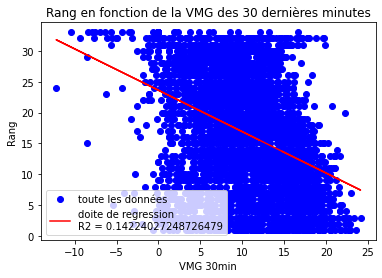

In [14]:
# on utilise le module LinearRegression de sklearn

# première regression sur la VMG des 30 dernières minutes
modelOLS_30min = LinearRegression(fit_intercept=True)
x = rang_VMG_numpy[:,0].reshape(-1, 1)
resultOLS_30min = modelOLS_30min.fit(x, rang_VMG_numpy[:,3])

fig, ax = plt.subplots()
ax.set_title("Rang en fonction de la VMG des 30 dernières minutes")
ax.plot(rang_VMG_numpy[:,0], rang_VMG_numpy[:,3], "bo", label ='toute les données')

y = [resultOLS_30min.intercept_ + x*resultOLS_30min.coef_ for x in rang_VMG_numpy[:,0]]
# j'ai ajouté le coefficient de détermination R2 afin de départager les trois regressions
ax.plot(rang_VMG_numpy[:,0], y, "r-", label = 'doite de regression \n' + 'R2 = ' + str(resultOLS_30min.score(x, rang_VMG_numpy[:,3])))

plt.xlabel("VMG 30min")
plt.ylabel("Rang")
plt.legend()

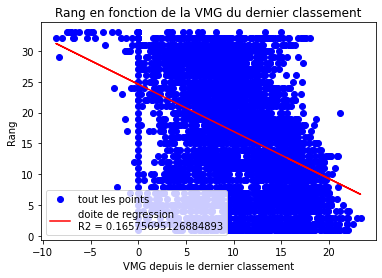

In [15]:
# seconde régression sur la VMG depuis le dernier classement 
modelOLS_classement = LinearRegression(fit_intercept=True)
x = rang_VMG_numpy[:,1].reshape(-1, 1)
resultOLS_classement = modelOLS_classement.fit(x, rang_VMG_numpy[:,3])

fig, ax = plt.subplots()
ax.set_title("Rang en fonction de la VMG du dernier classement")
ax.plot(rang_VMG_numpy[:,1], rang_VMG_numpy[:,3], "bo", label ='tout les points')

y = [resultOLS_classement.intercept_ + x*resultOLS_classement.coef_ for x in rang_VMG_numpy[:,1]]
ax.plot(rang_VMG_numpy[:,1], y, "r-", label = 'doite de regression \n' + 'R2 = ' + str(resultOLS_classement.score(x, rang_VMG_numpy[:,3])))

plt.xlabel("VMG depuis le dernier classement")
plt.ylabel("Rang")
plt.legend()

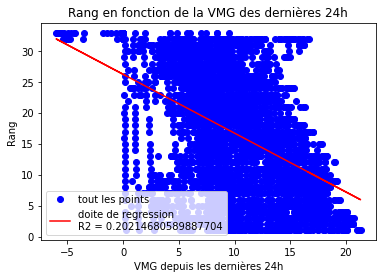

In [16]:
#troisième regression sur la VMG des 24 dernières heures
modelOLS_24h = LinearRegression(fit_intercept=True)
x = rang_VMG_numpy[:,2].reshape(-1, 1)
resultOLS_24h = modelOLS_24h.fit(x, rang_VMG_numpy[:,3])

fig, ax = plt.subplots()
ax.set_title("Rang en fonction de la VMG des dernières 24h")
ax.plot(rang_VMG_numpy[:,2], rang_VMG_numpy[:,3], "bo", label ='tout les points')

y = [resultOLS_24h.intercept_ + x*resultOLS_24h.coef_ for x in rang_VMG_numpy[:,2]]
ax.plot(rang_VMG_numpy[:,2], y, "r-", label = 'doite de regression \n' + 'R2 = ' + str(resultOLS_24h.score(x, rang_VMG_numpy[:,3])))

plt.xlabel("VMG depuis les dernières 24h")
plt.ylabel("Rang")
plt.legend()

On observe, comme on pouvait s'y attendre, une corrélation négative entre classement et vitesse utile. Néanmoins, le coefficient de détermination est assez faible (environ 0.20 pour la meilleur des droites de régression, celle sur la VMG des 24 dernières heures).

## Impact de la présence d'un foil sur le classement et la vitesse des voiliers

In [17]:
def impact_of_foil(df):
    # on crée une nouvelle colonne avec des valeurs booléennes sur la présence d'un foil sur le navire
    df["Presence d'un foil"] = df['Nombre de dérives'].apply(lambda x: True if 'foil' in x else False)
    result = []
    
    # on calcul la moyenne et l'écart-type pour le rang et la VMG des 24 dernières heures en fonction
    # de la présence d'un foil
    result.append((df["Rang"].loc[(df["Presence d'un foil"].apply(lambda x : x==True))]).mean())
    result.append((df["Rang"].loc[(df["Presence d'un foil"].apply(lambda x : x==True))]).std())
    result.append((df["Rang"].loc[(df["Presence d'un foil"].apply(lambda x : x==False))]).mean())
    result.append((df["Rang"].loc[(df["Presence d'un foil"].apply(lambda x : x==False))]).std())
    result.append((df['VMG Depuis 24 heures (kts)'].loc[(df["Presence d'un foil"].apply(lambda x : x==True))]).mean())
    result.append((df['VMG Depuis 24 heures (kts)'].loc[(df["Presence d'un foil"].apply(lambda x : x==True))]).std())
    result.append((df['VMG Depuis 24 heures (kts)'].loc[(df["Presence d'un foil"].apply(lambda x : x==False))]).mean())
    result.append((df['VMG Depuis 24 heures (kts)'].loc[(df["Presence d'un foil"].apply(lambda x : x==False))]).std())
    return result

In [18]:
result = impact_of_foil(df_merge) 
print("Lorsqu'il y a un foil, le rang moyen du skipper est " + str(int(result[0])) + " avec un écart type de " +str(int(result[1])) + ". Sa vitesse moyenne est de " + str(int(result[4])) + " avec un écart type de " + str(int(result[5])) + ".\nLorsqu'il n'y a pas de foil, le rang moyen du skipper est " + str(int(result[2])) + " avec un écart type de " + str(int(result[3])) + ". Sa vitesse moyenne est de " + str(int(result[6])) + " avec un écart type de " + str(int(result[7])) + ".")

Lorsqu'il y a un foil, le rang moyen du skipper est 14 avec un écart type de 9. Sa vitesse moyenne est de 10 avec un écart type de 4.
Lorsqu'il n'y a pas de foil, le rang moyen du skipper est 19 avec un écart type de 8. Sa vitesse moyenne est de 9 avec un écart type de 3.


Le foil semble avoir une influence sur le classement et la vitesse du skipper, mais il est difficile d'en être absolument sûr
au vu de la valeur de l'écart type.

## Visualisation de la distance parcourue par voilier

In [19]:
def visualisation_distance(df):
    skipper = df["Skipper"].unique()
    # on crée un dictionnaire ayant pour clé le nom du skipper et pour valeur un tuple avec la distance totale
    # qu'il a parcouru et son rang
    skipper_distance = {}
    for s in skipper:
        rang = df['Rang'].loc[(df["Skipper"] == s)]
        ranking = np.array(rang)[0]
        skipper_distance[s] = ((df['Distance Depuis le dernier classement (nm)'].loc[(df["Skipper"].apply(lambda x : x==s))]).sum()), ranking
    skipper_distance = sorted(skipper_distance.items(), key=lambda t: -t[1][0])
    return skipper_distance

In [20]:
dic_rank_distance = visualisation_distance(df_merge)
# on supprime Nicolas Troussel du traitement : voir commentaire en dessous 
# (il faussait la représentation, son dernier classement remonte à plusieurs jours)
for element in dic_rank_distance:
    if element[0] == 'Nicolas Troussel':
        dic_rank_distance.remove(element)

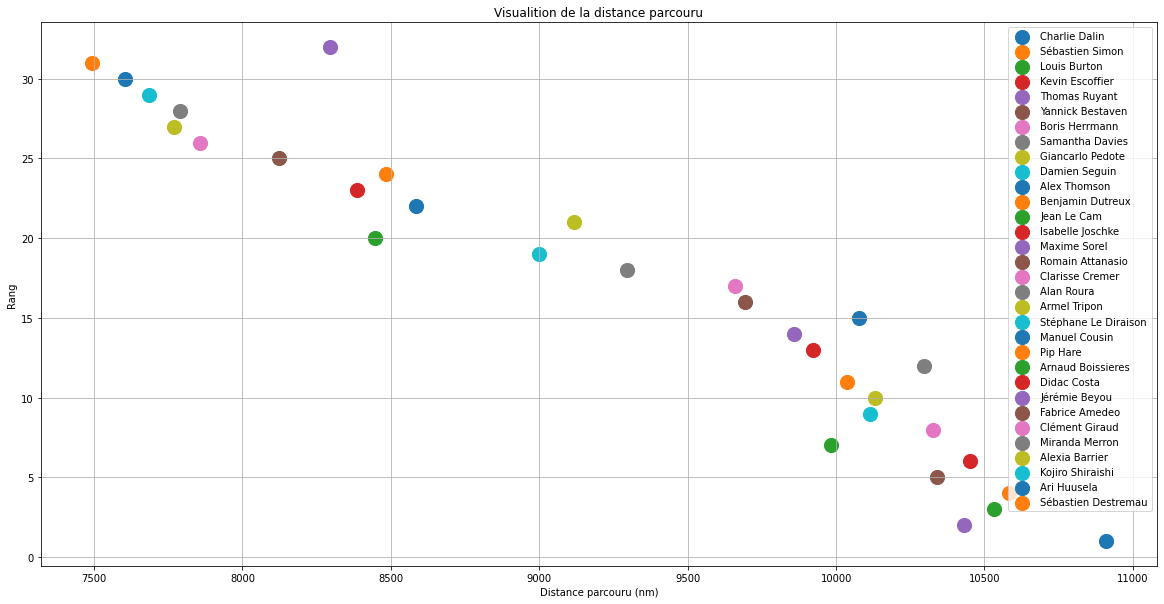

In [21]:
plt.subplots(figsize=(20, 10))
plt.title("Visualition de la distance parcouru")

for skipper in dic_rank_distance :
    plt.scatter(skipper[1][0], skipper[1][1], s = 200, label =skipper[0])

plt.xlabel("Distance parcouru (nm)")
plt.ylabel("Rang")
plt.grid()
plt.legend()

On peut remarquer que le classement ne correspond pas exactement à la distance parcourue par les skippers. les différences doivent venir du fait que la distance ne joue pas seulement : il faut aussi avoir un trajet optimisé afin de passer par le minimum de distance.

J'ai retiré Nicolas Troussel car il a abandonné suite à la casse de ses mâts : https://voilesetvoiliers.ouest-france.fr/course-au-large/vendee-globe/vendee-globe-nicolas-troussel-rejoint-au-cap-vert-par-le-pdg-de-corum-venu-le-soutenir-en-personne-2f3a1fdc-2cd6-11eb-8dc6-6ac08a19f000

## Cartes avec les routes d'un ou plusieurs voiliers selon diverses projections 

Cette partie a probablement été la plus difficile. J'ai du recommencer toutes cette partie à quelques heures du rendu du projet à cause d'une erreur complètement irrésolvable (a priori connu sur le web...) : "cannot import name 'pyproj_datadir' from 'pyproj.datadir'". J'ai mis à jour pyproj, et impossible suite à cela de charger la librairie, indispensable pour geopandas.

Je me suis donc tourné vers une autre librairie : cartopy. Il s'avère que cette dernière est bien plus simple d'utilisation et a un bien meilleur rendu. La multitude de ses projections est aussi cool.

Dans la suite je réaliserai les projections suivantes :

- PlateCarree, soit une projection cylindrique équidistante
- NearsidePerspective, soit une projection qui permet de conserver un maximum les proportions mais ne montrant qu'une partie du globe
- Sinusoidal, soit, comme son nom l'indique, une projection sinusoidale 

Afin que les cartes soient lisibles, je les ai aggrandis et je n'ai mis que trois skippers (le premier, Charlie, une skipprice en milieu de tableau, Samantha et un des derniers : Kojiro).


In [22]:
df_parcour = pd.DataFrame(df_merge[['Date', 'Skipper', 'Latitude', 'Longitude']])
df_parcour

,Date,Skipper,Latitude,Longitude
0,2020-11-30 21:00:00,Charlie Dalin,-40.816389,-16.296944
1,2020-11-30 21:00:00,Thomas Ruyant,-40.839167,-10.166667
2,2020-11-30 21:00:00,Louis Burton,-43.789444,-8.048889
3,2020-11-30 21:00:00,Sébastien Simon,-40.511667,-8.510278
4,2020-11-30 21:00:00,Yannick Bestaven,-39.093333,-8.702500
...,...,...,...,...
4393,2020-11-08 14:00:00,Alexia Barrier,46.439722,-0.174444
4394,2020-11-08 14:00:00,Isabelle Joschke,46.427222,-0.193889
4395,2020-11-08 14:00:00,Sébastien Simon,46.437500,-0.179722
4396,2020-11-08 14:00:00,Miranda Merron,46.427500,-0.190556


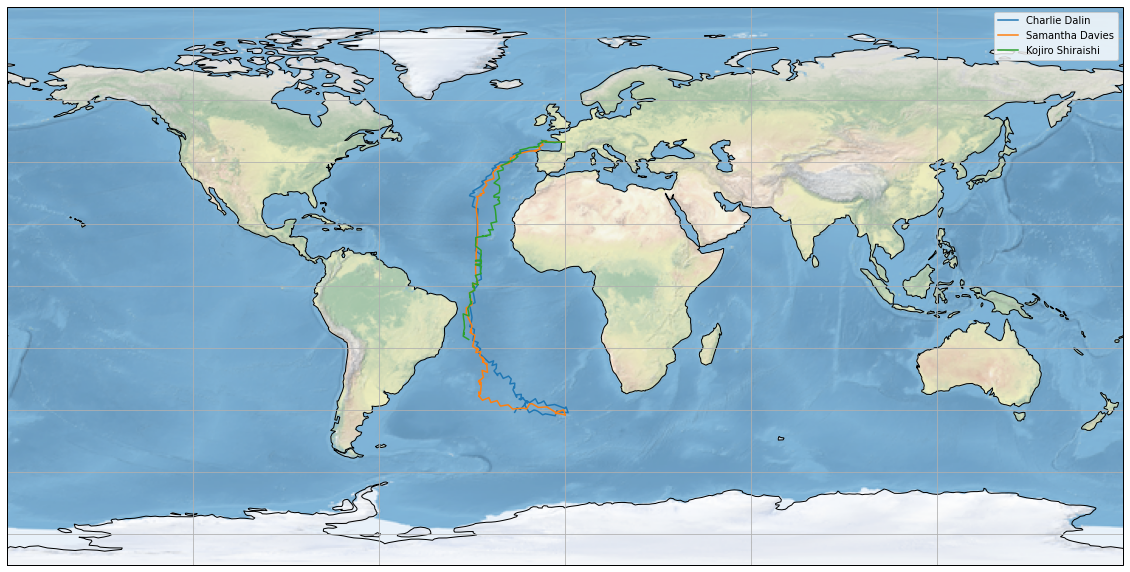

In [23]:
# PlateCarree

plt.figure(figsize=(20, 20))

ax = plt.axes(projection=ctp.crs.PlateCarree())

ax.add_feature(ctp.feature.OCEAN)
ax.add_feature(ctp.feature.COASTLINE)
ax.gridlines()
ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))], df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))], label ='Charlie Dalin')

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))], df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))], label ='Samantha Davies')

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))], df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))], label ='Kojiro Shiraishi')
plt.legend()

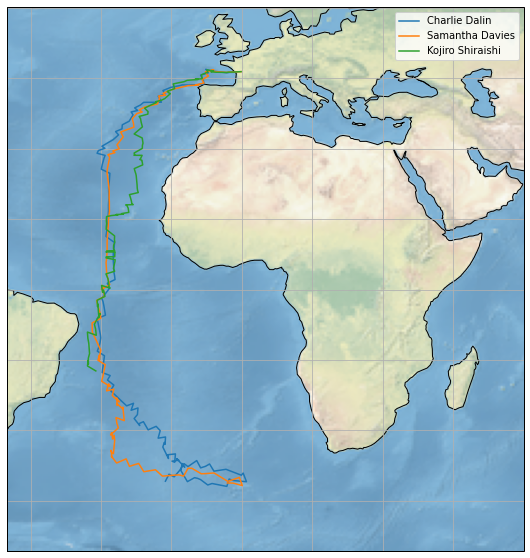

In [24]:
# PlateCarree + set_extent

plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ctp.crs.PlateCarree())

ax.set_extent([-50, 60, -40, 45])
ax.add_feature(ctp.feature.OCEAN)
ax.add_feature(ctp.feature.COASTLINE)
ax.gridlines()
ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))], df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))], label ='Charlie Dalin')

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))], df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))], label ='Samantha Davies')

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))], df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))], label ='Kojiro Shiraishi')
plt.legend()

On peut aisément suivre leur route sur cette carte zommé sur l'Afrique et l'Europe. D'ici quelques jours, elle ne sera plus d'actualité !

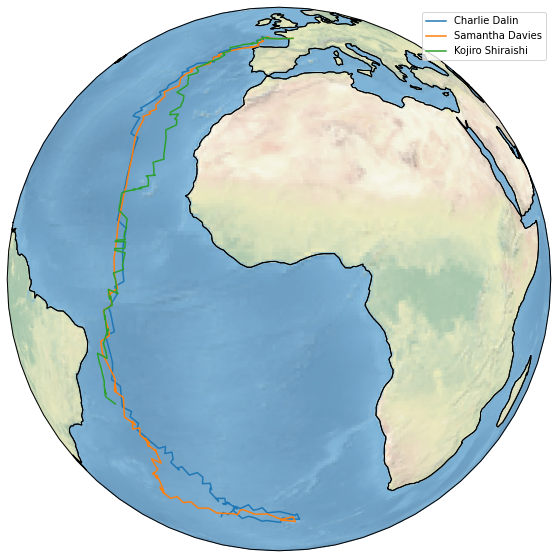

In [25]:
# NearsidePerspective
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ctp.crs.NearsidePerspective(
                        central_latitude=2.72,
                        central_longitude=-3.53,
                        satellite_height=10000000.0))
ax.add_feature(ctp.feature.OCEAN)
ax.add_feature(ctp.feature.COASTLINE)
ax.add_feature(ctp.feature.LAND)
ax.coastlines(resolution='110m')
ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))],
         df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))],
         label ='Charlie Dalin',
        transform=ctp.crs.PlateCarree())

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))],
         df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))],
         label ='Samantha Davies',
        transform=ctp.crs.PlateCarree())

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))],
         df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))],
         label ='Kojiro Shiraishi',
        transform=ctp.crs.PlateCarree())

plt.legend()

Probablement ma représentation préféré !

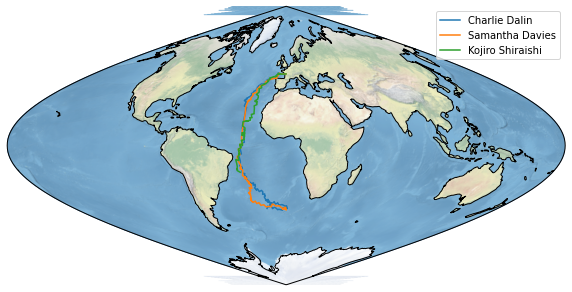

In [26]:
# Sinusoidal

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ctp.crs.Sinusoidal())
ax.add_feature(ctp.feature.OCEAN)
ax.add_feature(ctp.feature.COASTLINE)
ax.add_feature(ctp.feature.LAND)

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))],
         df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Charlie' in str(x))],
         label ='Charlie Dalin',
        transform=ctp.crs.PlateCarree())

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))],
         df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Samantha' in str(x))],
         label ='Samantha Davies',
        transform=ctp.crs.PlateCarree())

ax.stock_img()
plt.plot(df_parcour['Longitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))],
         df_parcour['Latitude'].loc[df_parcour['Skipper'].apply(lambda x : 'Kojiro' in str(x))],
         label ='Kojiro Shiraishi',
        transform=ctp.crs.PlateCarree())

plt.legend()

Celle ci est... Artistique ?

## Analyses de séries temporelles

Pour cette partie j'ai choisi de représenté l'évolution du classement de quatre skipper au cours du temps (la première colonne du df son des objets Datetime, interprétable par matplotlib).

Je me suis limité à quatre skippers afin d'assurer la lisibilité du graphe.

In [27]:
# se concentrer sur un seule coureur avec l'évolution de son classement au cours du temps 
def serie_temp_classement(df):
    skipper = df["Skipper"].unique()
    
    plt.subplots(figsize=(15, 7))
    plt.title("Evolution du rang au cours du temps")
    
    for s in skipper[:4]:
        rang = df['Rang'].loc[(df["Skipper"] == s)]
        dates = df['Date'].loc[(df["Skipper"] == s)]
        plt.plot(dates, rang, label = s)
    
    plt.xlabel("Date")
    plt.ylabel("Rang")
    plt.legend()
    return 

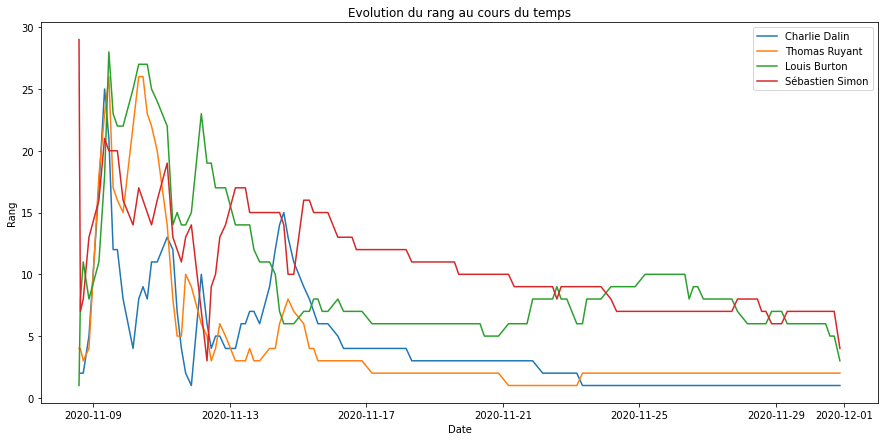

In [28]:
serie_temp_classement(df_merge)

La première semaine de compétition est comme on peut s'y attendre, très chaotique en terme de classement.

Néanmoins après la troisième semaine, les postions se stabilisent. La troisième et quatrième place semble très disputé entre les skipper Louis Burton et Sébastien Simon.

## Application d'algorithmes statistiques

J'ai implémenté dans la suite un algorithme de sélection de variables à l'aide de la Tstat.

Cette algo renvoie la liste ordonnée des variables en fonction de leur influence sur le classement.

Dans l'espace des features, on trouvera toutes les variables numériques : 
- Vitesse Depuis 30 minutes (kts)	
- VMG Depuis 30 minutes (kts)	
- Distance Depuis 30 minutes (nm)	
- Vitesse Depuis le dernier classement (kts)
- VMG Depuis le dernier classement (kts)
- Distance Depuis le dernier classement (nm)
- Vitesse Depuis 24 heures (kts)
- VMG Depuis 24 heures (kts)
- Distance Depuis 24 heures (nm)
- DTF
- DTL	
- Largeur
- Tirant d'eau
- Hauteur mât
- Surface de voiles au près
- Surface de voiles au portant

Et dans l'espace des labels, les classements.

On ne considère pas le poids, il y a des données manquantes et peu de variabilité entre les bateaux. On ne considère pas le tirant d'eau et la longueur car tout les bateaux ont les même caractéristiques.

On va chercher à trouver quels variables expliquent le mieux le rang du skipper.

In [29]:
def tstatistique(coeff, residus, Xk):
    sigma_chapeau = ((np.linalg.norm(residus))**2)/(len(Xk) - 1)
    tstat = coeff / (sigma_chapeau**(1/2) * np.dot(Xk.T, Xk)**(-1/2))
    return tstat

In [30]:
def forwardVS(X, Y, k):
    # il s'agit d'un algo que nous avons étudiés en statistique
    # je l'ai moi-même implémenté.
    X_forward = []
    index_select = []
    predict = Y
    X_scaled = preprocessing.scale(X)
    while(len(X_forward) < k):
        max_tstat = 0
        i = 0
        for column in X_scaled.T:
            if i in index_select:
                i += 1
                continue
            predict_scaled = preprocessing.scale(predict)
            model = LinearRegression(fit_intercept=False)
            result = model.fit(column.reshape(-1, 1) , predict)
            residus = predict - result.predict(column.reshape(-1, 1))
            tstat = tstatistique(abs(result.coef_[0]), residus, column)
            if(tstat>max_tstat):
                max_tstat = tstat
                var_select = column
                predict = residus
                index = i
            i += 1
        X_forward.append(var_select)
        index_select.append(index)
    X_forward = np.array(X_forward).T
    return X_forward, index_select

On isole les variables numériques interessantes :

In [31]:
num_variable = [8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 27, 31, 33, 34, 1]
df_merge_simplify = df_merge.iloc[:,num_variable]

In [32]:
X = df_merge_simplify.iloc[:,0:-1].to_numpy()
Y = df_merge_simplify.iloc[:,-1].to_numpy()
X_forward, index_select = forwardVS(X, Y, 15)
variables_grande_influence = df_merge_simplify.iloc[:,index_select]
print("on affiche les variables numériques dans l'ordre de leur influence : (gauche vers droite)")
variables_grande_influence

on affiche les variables numériques dans l'ordre de leur influence : (gauche vers droite)


,DTL (nm),DTF (nm),Vitesse Depuis 30 minutes (kts),Surface de voiles au près,Hauteur mât,Vitesse Depuis 24 heures (kts),VMG Depuis le dernier classement (kts),VMG Depuis 30 minutes (kts),Distance Depuis 24 heures (nm),VMG Depuis 24 heures (kts),Largeur,Surface de voiles au portant,Vitesse Depuis le dernier classement (kts),Distance Depuis 30 minutes (nm),Distance Depuis le dernier classement (nm)
0,0.0,17584.6,14.8,350,29,16.8,15.7,14.8,403.4,16.6,5.85,560,16.2,7.4,64.8
1,258.2,17842.8,19.5,350,29,17.3,18.4,19.3,406.4,17.2,5.85,560,18.5,9.7,46.4
2,302.3,17886.9,18.5,300,28,18.5,17.9,18.3,443.3,18.4,5.80,600,18.0,9.2,72.1
3,355.2,17939.8,14.5,260,29,16.9,15.7,11.7,404.5,16.8,5.70,600,16.3,1.2,65.4
4,372.9,17957.6,7.6,310,29,14.8,1.9,-5.4,356.2,14.8,5.80,550,9.9,0.6,39.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,1.6,24295.4,10.9,260,29,0.6,0.0,10.8,4.5,0.4,5.54,580,0.0,0.2,2789.4
4394,1.6,24295.5,13.8,300,27,0.2,0.0,13.5,5.2,0.2,5.60,650,0.0,0.2,2788.5
4395,1.6,24295.5,13.4,260,29,0.2,0.0,13.4,4.5,0.1,5.70,600,0.0,0.7,2789.3
4396,1.7,24295.6,11.4,330,28,0.2,0.0,11.3,4.8,0.2,5.50,600,0.0,0.4,2788.9


D'après cette algo, le DTL, DTF et la vitesse depuis les 30 dernières minutes sont les variables qui influencent le plus le rang du skipper.

Dans la suite, nous allons vérifier cette informations avec le lassoCV : la fonction scikitlearn calculant la regression lasso à l'aide de la cross validation.

In [33]:
# on prend une plage de recherche du lambda suffisamment large : de 0.1 à 100 avec un pas de 0.1
lambda_param = [x/10 for x in range(1, 1000)]
model_lasso = LassoCV(alphas = lambda_param, cv = 5)
result_lasso = model_lasso.fit(X, Y)

importance = np.abs(result_lasso.coef_)

lasso_selection = {}
k = 0
for element in importance : 
    if(element > 0):
        lasso_selection[k] = element 
    k += 1
lasso_selection = sorted(lasso_selection.items(), key=lambda t: -t[1])
index_lasso = []
for element in lasso_selection:
    index_lasso.append(element[0])
variables_lasso_influence = df_merge_simplify.iloc[:,index_lasso]
variables_lasso_influence

,Surface de voiles au près,Distance Depuis 24 heures (nm),DTL (nm),DTF (nm),Distance Depuis le dernier classement (nm),Surface de voiles au portant
0,350,403.4,0.0,17584.6,64.8,560
1,350,406.4,258.2,17842.8,46.4,560
2,300,443.3,302.3,17886.9,72.1,600
3,260,404.5,355.2,17939.8,65.4,600
4,310,356.2,372.9,17957.6,39.7,550
...,...,...,...,...,...,...
4393,260,4.5,1.6,24295.4,2789.4,580
4394,300,5.2,1.6,24295.5,2788.5,650
4395,260,4.5,1.6,24295.5,2789.3,600
4396,330,4.8,1.7,24295.6,2788.9,600


Les colonnes sont triés par ordre d'influence des variables sur le rang. Selon le Lasso, les seuls variables influençant le rang du skipper sont le suivantes :
- Surface de voiles au près	
- Distance Depuis 24 heures (nm)	
- DTL	
- DTF	
- Distance Depuis le dernier classement (nm)	
- Surface de voiles au portant

La première variable est une caractéristique du bateau (la surface de voiles au près). C'est interessant car selon le Lasso, cette variable est plus influente que des caractéristiques de la course (comme la distance parcourue les 24 dernières heures ou le DTL). 

On ne peut que conseiller aux skippers d'avoir une surface de voiles au près la plus grande possible !

J'ai choisi de me restreindre dans l'analyse suivante aux caractéristiques des bateaux : la largeur, la hauteur du mât, la surface de voiles au portant et la surface de voiles au près afin de faire abstraction des caractéristiques de la course.

In [34]:
num_variable = [27, 31, 33, 34, 1]
df_merge_simplify = df_merge.iloc[:,num_variable]

X = df_merge_simplify.iloc[:,0:-1].to_numpy()
Y = df_merge_simplify.iloc[:,-1].to_numpy()
X_forward, index_select = forwardVS(X, Y, 4)
variables_grande_influence = df_merge_simplify.iloc[:,index_select]
variables_grande_influence

,Surface de voiles au près,Hauteur mât,Largeur,Surface de voiles au portant
0,350,29,5.85,560
1,350,29,5.85,560
2,300,28,5.80,600
3,260,29,5.70,600
4,310,29,5.80,550
...,...,...,...,...
4393,260,29,5.54,580
4394,300,27,5.60,650
4395,260,29,5.70,600
4396,330,28,5.50,600


In [35]:
model_lasso = LassoCV(alphas = lambda_param, cv = 5)
result_lasso = model_lasso.fit(X, Y)

importance = np.abs(result_lasso.coef_)

lasso_selection = {}
k = 0
for element in importance : 
    if(element > 0):
        lasso_selection[k] = element 
    k += 1
lasso_selection = sorted(lasso_selection.items(), key=lambda t: -t[1])
index_lasso = []
for element in lasso_selection:
    index_lasso.append(element[0])
variables_lasso_influence = df_merge_simplify.iloc[:,index_lasso]
variables_lasso_influence

,Hauteur mât,Surface de voiles au près,Largeur,Surface de voiles au portant
0,29,350,5.85,560
1,29,350,5.85,560
2,28,300,5.80,600
3,29,260,5.70,600
4,29,310,5.80,550
...,...,...,...,...
4393,29,260,5.54,580
4394,27,300,5.60,650
4395,29,260,5.70,600
4396,28,330,5.50,600


Les deux méthodes de sélections semblent d'accord sur les variables influençant le moins le classement : la largeur du bateau et la surface de voiles au portant.

Néanmoins, alors que la première application du Lasso sur les variables avait conclu que la variable influençant le plus le rang était la surface de voiles au près, cette fois-ci il conclu que la hauteur du mat influence le plus (cela montre la faible vraisemblance de notre modèle : la hauteur du mat fluctue très peu entre les navires).

On peut considérer que la caractéristique du bateau affectant le plus le classement est la surface de voiles au près.

Merci pour l'attention porté à mon projet et bonne continuation !